In [1]:
import torch
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def create_quad(n: int, a: float, b: float, c: float) -> list:
  x = torch.arange(-1, 1, step=2./n).reshape(-1, 1)
  x = x + torch.randn_like(x) / 3
  y = a * x * x + b * x + c
  y = y + torch.randn_like(y) / 3

  return x, y

In [3]:
def mse_loss(y_hat, y):
  diff = y_hat - y
  diff = diff.pow(2)
  mse = diff.mean() / 2
  return mse

$f(x) = x^2$

$f'(x) = 2x$

In [4]:
def min_max_norm(x, xmin=None, xmax=None):
  if xmin is None:
    xmin, _ = x.min(dim=0, keepdim=True)
  if xmax is None:
    xmax, _ = x.max(dim=0, keepdim=True)
  diff = xmax - xmin
  x = 2 * (x - xmin) / diff - 1
  return x, xmin, xmax

In [5]:
x_quad, y_quad = create_quad(a=2, b=3, c=1, n=300)
x_quad_test, y_quad_test = create_quad(a=2, b=3, c=1, n=100)

x_quad_norm, x_quad_min, x_quad_max = min_max_norm(x_quad)
y_quad_norm, y_quad_min, y_quad_max = min_max_norm(y_quad)
x_quad_test_norm, _, _ = min_max_norm(x_quad_test, x_quad_min, x_quad_max)
y_quad_test_norm, _, _ = min_max_norm(y_quad_test, y_quad_min, y_quad_max)

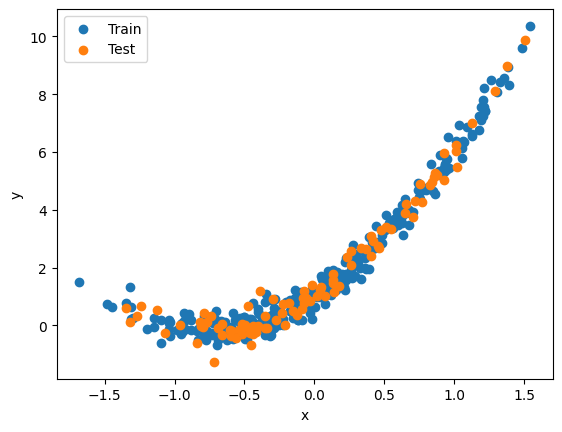

In [6]:
plt.scatter(x_quad, y_quad, label='Train')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_quad_test, y_quad_test, label='Test')
plt.legend()
plt.savefig('non-linear_data.pdf')

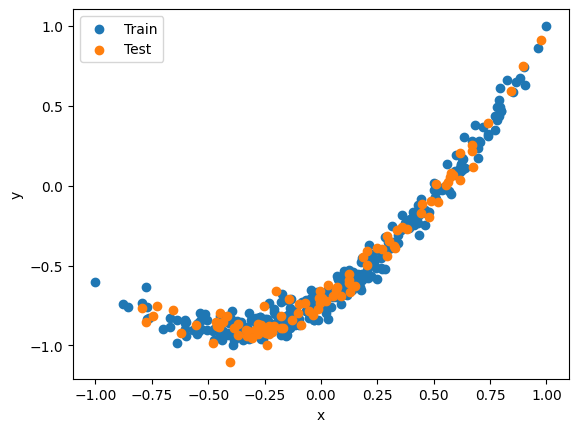

In [7]:
plt.scatter(x_quad_norm, y_quad_norm, label='Train')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_quad_test_norm, y_quad_test_norm, label='Test')
plt.legend()
plt.savefig('non-linear_data.pdf')

In [8]:
def plot_fit(ei, w):
  plt.figure(ei)
  x_quad_deg = torch.cat([x_quad_norm.pow(i) for i in range(deg)], dim=1)
  x_quad_test_deg = torch.cat([x_quad_test_norm.pow(i) for i in range(deg)], dim=1)

  x_linspace = torch.arange(-1., 1.02, 0.01).reshape(-1, 1)
  x_lindeg = torch.cat([x_linspace.pow(i) for i in range(deg)], dim=1)
  y_linpred = x_lindeg @ w

  plt.plot(x_linspace, y_linpred)


  y_quad_pred = x_quad_deg @ w
  y_quad_test_pred = x_quad_test_deg @ w

  plt.scatter(x_quad_norm, y_quad_norm, label='Train')
  plt.scatter(x_quad_test_norm, y_quad_test_norm, label='Test')

  plt.scatter(x_quad_norm, y_quad_pred, marker='*', label='pred train')
  plt.scatter(x_quad_test_norm, y_quad_test_pred, marker='^', label='pred test')
  plt.title('ei ' + str(ei))
  plt.legend()

In [9]:
def train(x, y, x_test, y_test, w, nepoch=100, lr=1e-3, deg=2, Lambda=0.000):
  ones = torch.ones_like(x)

  x = torch.cat([x.pow(i) for i in range(deg)], dim=1)
  ones = torch.ones_like(x_test)
  x_test = torch.cat([x_test.pow(i) for i in range(deg)], dim=1)
  print(x.size())
  losses = []
  test_losses = []
  for ei in range(nepoch):
    y_pred = torch.matmul(x, w)
    lossi = mse_loss(y_pred, y) + Lambda * torch.sum(torch.abs(w))
    grad = torch.matmul(x.T, (y_pred-y)) / len(y) + Lambda * torch.sign(w)
    w -= lr*grad

    # d mse / dw = from the previous lecture
    # d reg / dw = Lambda * (dấu của W : 1 nếu w dương , -1 nếu w âm , 0 nếu w = 0)
    # dL / dw = d mse / dw + d reg / dw

    y_hat_test = x_test @ w
    test_lossi = mse_loss(y_hat_test, y_test)
    losses.append(lossi.item())
    test_losses.append(test_lossi.item())

    if ei % 100 == 0:
      plot_fit(ei, w)
  return w, losses, test_losses

torch.Size([300, 21])


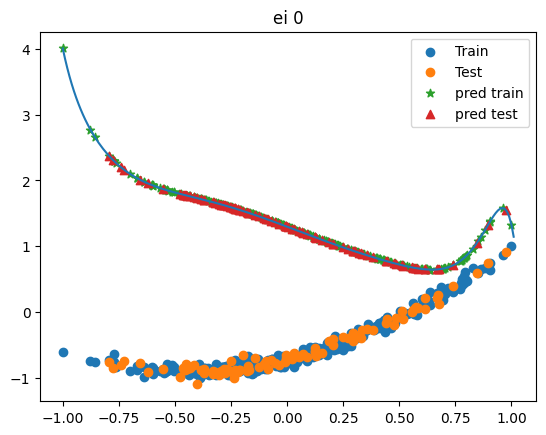

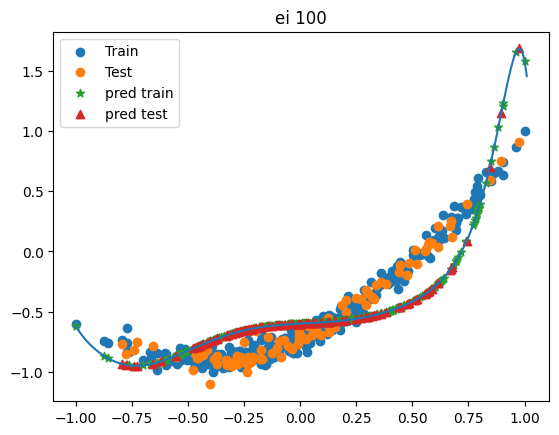

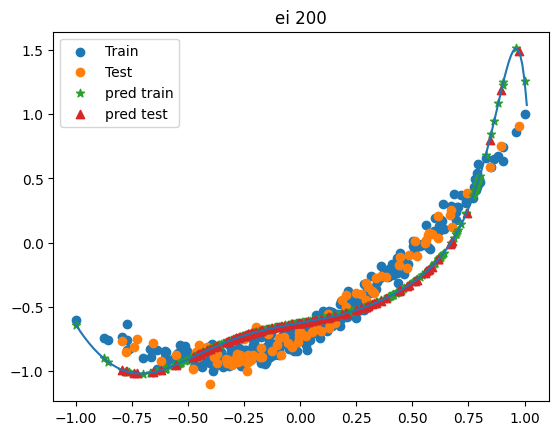

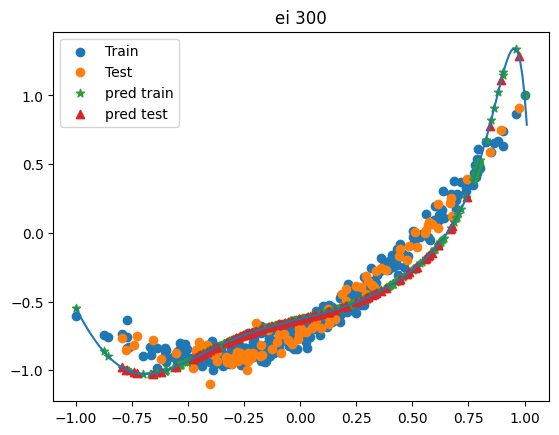

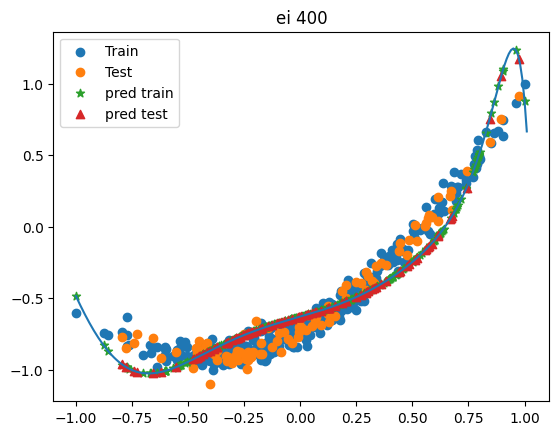

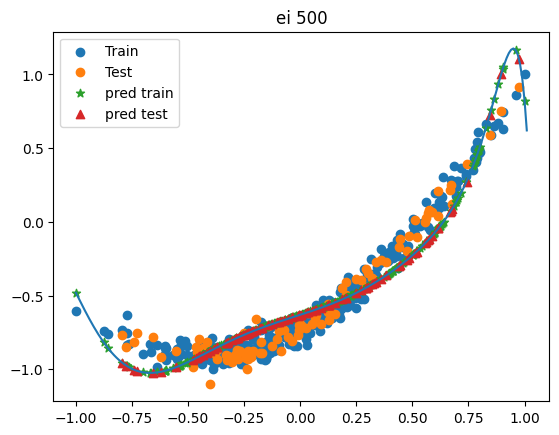

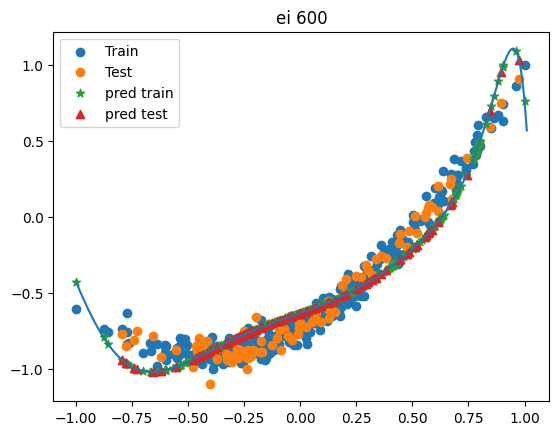

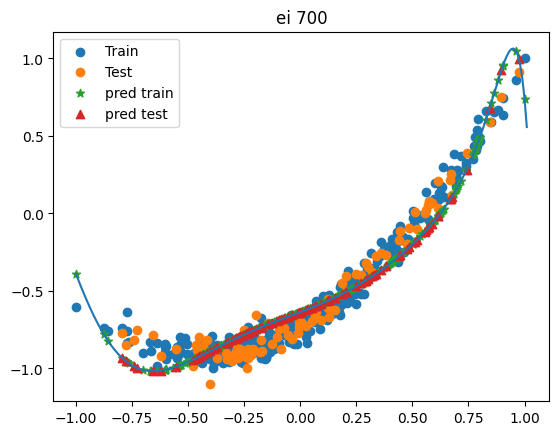

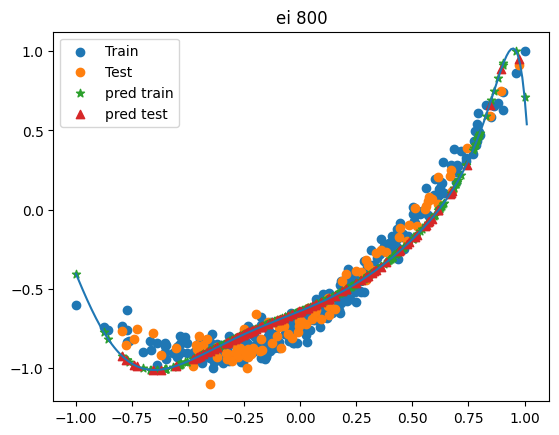

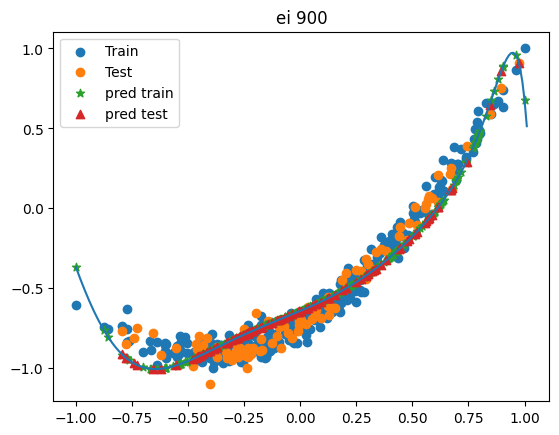

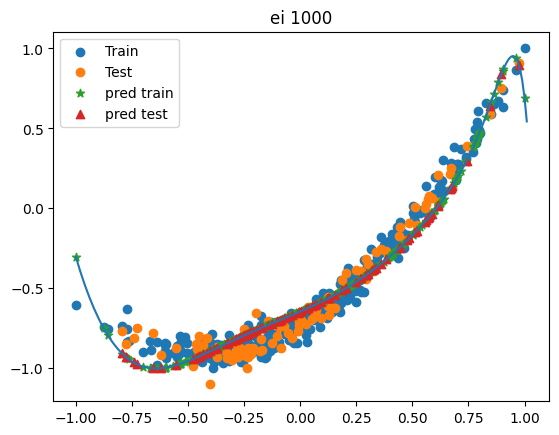

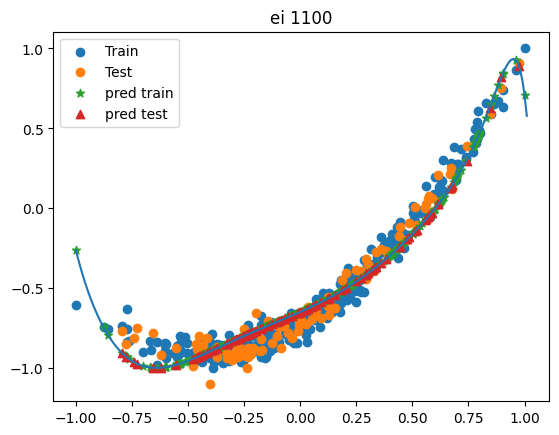

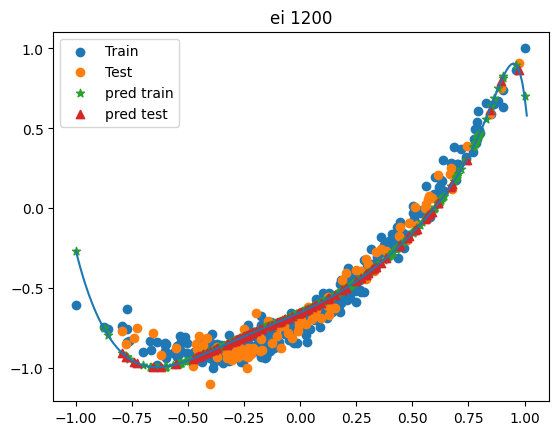

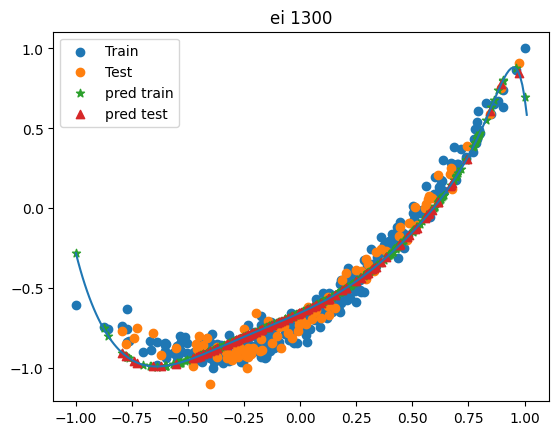

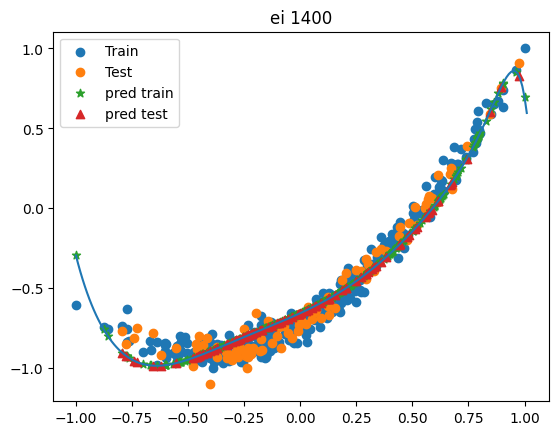

In [10]:
# torch.random.manual_seed(0)
deg = 20 + 1
w = torch.randn(deg, 1)
w, losses, test_losses = train(x=x_quad_norm, y=y_quad_norm,
                               x_test=x_quad_test_norm,
                               y_test=y_quad_test_norm,
                               w=w, lr=0.1, nepoch=1500, deg=deg, Lambda=0.005)

In [11]:
w

tensor([[-6.5954e-01],
        [ 6.5508e-01],
        [ 4.3737e-01],
        [ 8.7418e-01],
        [ 2.1305e-04],
        [-1.2352e+00],
        [ 3.8682e-01],
        [ 4.9433e-01],
        [ 3.9571e-01],
        [ 5.1399e-04],
        [ 2.1607e-04],
        [ 1.6556e-01],
        [-4.0609e-04],
        [ 3.5331e-02],
        [-4.8177e-04],
        [ 5.9247e-04],
        [-4.4710e-04],
        [ 3.8918e-05],
        [ 1.6179e-04],
        [-4.8516e-01],
        [-3.6259e-01]])

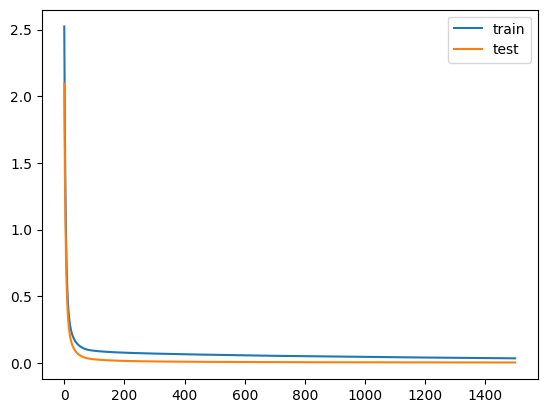

In [12]:
plt.plot(losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

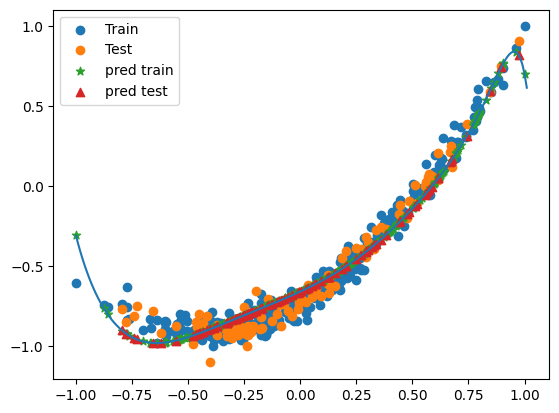

In [13]:
x_quad_deg = torch.cat([x_quad_norm.pow(i) for i in range(deg)], dim=1)
x_quad_test_deg = torch.cat([x_quad_test_norm.pow(i) for i in range(deg)], dim=1)

x_linspace = torch.arange(-1., 1.02, 0.01).reshape(-1, 1)
x_lindeg = torch.cat([x_linspace.pow(i) for i in range(deg)], dim=1)
y_linpred = x_lindeg @ w

plt.plot(x_linspace, y_linpred)


y_quad_pred = x_quad_deg @ w
y_quad_test_pred = x_quad_test_deg @ w

plt.scatter(x_quad_norm, y_quad_norm, label='Train')
plt.scatter(x_quad_test_norm, y_quad_test_norm, label='Test')

plt.scatter(x_quad_norm, y_quad_pred, marker='*', label='pred train')
plt.scatter(x_quad_test_norm, y_quad_test_pred, marker='^', label='pred test')
plt.legend()